In [1]:
master_path ='..\..\Raw_Data\\Bioreactor_Data\\GAuDi'

In [17]:
from lib.tools import *

In [3]:
#Continuous estimation of growth rate by fitting a linear curve to a sliding window of log(OD) with respect to time
def cont_growth_rate(data,sli):
    dil = data.data_to_df('dilutions')
    od = data.data_to_df('ODs')
    delta_dils = dil['rel_time_hrs'].diff()
    I_dil_start = delta_dils > 0.05
    prev = False
    growth_phases = []
    for k,v in I_dil_start.items():
        if v:
            t1 = dil['rel_time_hrs'].iloc[k-1]
            t2 = dil['rel_time_hrs'].iloc[k]
            growth_phases.append((t1,t2))
    growth_rate_per_hr = []
    time_s = []
    fitted_od = []
    fitted_time = []
    o_fitted_od = []
    o_fitted_time = []
    sli =30
    for t1,t2 in growth_phases:
        try:
            od_phase = od[(od['rel_time_hrs']>t1) & (od['rel_time_hrs']<t2)]
            od_phase = od_phase.reset_index(drop=True)
            if od_phase['OD'].max() - od_phase['OD'].min() > 0.05:
                fit_time = od_phase['rel_time_hrs']-od_phase['rel_time_hrs'][0]
                o_fit_time = od_phase['rel_time_hrs']-od_phase['rel_time_hrs'][0]
                o_pfit = np.polyfit(o_fit_time, np.log(od_phase['OD']), 1)
                o_fit_od = np.exp(o_fit_time*o_pfit[0] +o_pfit[1])
                o_fitted_time.extend(od_phase['rel_time_hrs'])
                o_fitted_od.extend(o_fit_od)
                for jj in range(0,len(od_phase)):
                        if len(od_phase['OD'][jj:-1]) >= sli:
                            pfit = np.polyfit(fit_time[jj:jj+sli], np.log(od_phase['OD'][jj:jj+sli]), 1)
                           # print(pfit[0])
                            fit_od = np.exp(fit_time[jj:jj+sli]*pfit[0] +pfit[1])
                           # print(fit_od)
                            fitted_od.extend(fit_od)
                            fitted_time.extend(od_phase['rel_time_hrs'][jj:jj+sli])

                            time_s.append((od_phase['rel_time_hrs'][jj] +od_phase['rel_time_hrs'][jj+sli])/2)
                            growth_rate_per_hr.append(pfit[0])

                        elif len(od_phase['OD'][jj:-1]) >=sli/1.5:
    #                         print('holla at ye')
                            pfit = np.polyfit(fit_time[jj:-1], np.log(od_phase['OD'][jj:-1]), 1)
                            fit_od = np.exp(fit_time[jj:-1]*pfit[0] +pfit[1])
                            fitted_od.extend(fit_od)
                            fitted_time.extend(od_phase['rel_time_hrs'][jj:-1])
                            time_s.append((od_phase['rel_time_hrs'][jj] + od_phase['rel_time_hrs'].iloc[-1])/2)
    #                         print(pfit[0])
                            growth_rate_per_hr.append(pfit[0])

                        else:
                            pass

        except:
            pass
    gr = pd.DataFrame.from_dict({'growth_rate_per_hr':growth_rate_per_hr,
                                'rel_time_hrs':time_s})

    return(gr)


In [4]:
# GauDi Model

def model(t,y,params,u):
    g = y[0]
    p = y[1]
    e = y[2]
    d = y[3]
    gg = 0.4
    gp = 0.02
    ge = 0.4
    kappa = (g/(g+p+e+d))*gg + (p/(g+p+e+d))*gp +(e/(g+p+e+d))*ge 
    dgdt = g *(gg-(params[0]+(params[1]*u))-kappa)
    dpdt = p*(gp-params[2]-params[3]-kappa) + g*((params[1]*u) + params[0] )
    dedt = p*params[2] + e*(ge-kappa)
    dddt = p*params[3] -d*(kappa)
    dydt = [dgdt,dpdt,dedt,dddt]
    return dydt

In [5]:

def fitted_data(data,t_start,thresh1=0.05,thresh2=0.95):
#Extracting state and induction information from cytometry data

# ARGUMENTS

# data is a reactordata object 
# t_start is the time after which the cytometry data is included in analysis, typically the time when cultures stabilise growth rates
# thresh1 is the threshold for size gating kept lenient to account for change of size
# thresh2 is the doublet removel threshold, kept lenient to account for change in cell physiology and catch dead cells

# RETURNS

# t, the time of cytometry measurements
# df, an array containing the fraction of each species (differentiated, non-differentiated and dead)
# t_span, tuple containing time of change of light induction 
    t_span = []
    ol_tp = 0
    u = 0
    for tp in data.LEDs_changes.loc[data.LEDs_changes['rel_time_hrs']>t_start]['rel_time_hrs']:
        shifter = data.LEDs_changes[data.LEDs_changes['rel_time_hrs']==tp].index.values
        t_span.append((ol_tp,tp,u))
        ol_tp = tp
        u = data.LEDs_changes['intensity'][shifter[0]]/40
    
    t_span.append((ol_tp,data.LEDs['rel_time_hrs'].iloc[-1],u))
    df_ODs = data.data_to_df('ODs')
    t0 = df_ODs['time_s'].iloc[0]
    for df in [df_ODs, data.cells]:
        df['rel_time_hrs'] = (df['time_s'] - t0) / 3600.
        
    gk = data.cells.groupby('rel_time_hrs')
    tz= np.unique(np.array(data.cells['rel_time_hrs']))
    t = tz[tz>t_start]
    fps = ['mCerulean','mNeonGreen','mVenus','mScarletI','SSC-HLin']
    thresh_fp = [100, 200,50,500]
    n_events = 5000
    rec_frac = np.zeros((np.size(t), 1))
    dead_frac = np.zeros((np.size(t), 1))
    t_del = []
    for jj in range(1,np.size(t)+1):
        lk = gk.get_group(t[jj-1])
        if (lk.size)/21 > 10*n_events:
            print('Not enough events read Kafka yo')
            t_del.append(t[jj-1])
        else:
            sz_lk = lk.loc[(lk['gating-metric'] >= thresh1)]
            db_lk = sz_lk.loc[(sz_lk['doublet-metric'] <= thresh2)]
            rec_cells = db_lk.loc[(((db_lk[fps[3]]/db_lk[fps[4]])*np.mean(db_lk[fps[4]]))>thresh_fp[3])]
            rec_frac[jj-1] = rec_cells[fps[3]].count()/( db_lk[fps[3]].count())
            dead_cells = db_lk.loc[(((db_lk[fps[1]]/db_lk[fps[4]])*np.mean(db_lk[fps[4]]))<thresh_fp[0]) & ( ((db_lk[fps[3]]/db_lk[fps[4]])*np.mean(db_lk[fps[4]]))<thresh_fp[0]) ]
            dead_frac[jj-1] = dead_cells[fps[3]].count()/( db_lk[fps[3]].count())

    nonrec_frac = 1-rec_frac- dead_frac 
    rec_live = rec_frac/(rec_frac + nonrec_frac)
    nonrec_live = nonrec_frac/(rec_frac + nonrec_frac)
    df = np.column_stack((rec_frac,nonrec_frac, dead_frac))

    
    return(t,df,t_span);


def fitting(params,inits,t_data,t_span):
    
#Solves the model for parameters (params) and initial conditions (inits) 
    
# and returns the model predictions (to_fit) and culture growth rate (kappa) 
# for times at which cytometry measurements were made (t_data)
# t_span provides the spans over which the model is solved piecewise for a constant light signal
    
    # solve ODE
    z0 = [inits[0],inits[1],inits[2],inits[3]]
    nt =[]
    g=[]
    p =[]
    e = []
    d =[]
    kappa = []
    gg = 0.4
    gp = 0.02
    ge = 0.4
    for tuples in t_span:
        t_eval = []
        tspan = (tuples[0],tuples[1])
        for tp in t_data:
            if ((tp>tuples[0]) and (tp<tuples[1])):
                t_eval.append(tp) 
        t_eval.append(tuples[1])    
        u = tuples[2]

        z = solve_ivp(model,tspan,np.asarray(z0),method='LSODA',t_eval = t_eval,args=(params,u))
        # store solution for plotting
        nt.append(z.y[0][:-1] +z.y[1][:-1] +z.y[2][:-1] +z.y[3][:-1])
        g.append(z.y[0][:-1])
        p.append(z.y[1][:-1])
        e.append(z.y[2][:-1])
        d.append(z.y[3][:-1])
        z0 = [z.y[0][-1],z.y[1][-1],z.y[2][-1], z.y[3][-1]]

            ########################## Calculating fractions #################   
    kappa = (np.concatenate( g, axis=0 )/np.concatenate( nt, axis=0 ))*gg + (np.concatenate( p, axis=0 )/np.concatenate( nt, axis=0 ))*gp +(np.concatenate( e, axis=0 )/np.concatenate( nt, axis=0 ))*ge
    nr = np.concatenate(p, axis=0 )/np.concatenate( nt, axis=0 ) +np.concatenate( e, axis=0 )/np.concatenate( nt, axis=0 )
    nd = np.concatenate(d, axis=0 )/np.concatenate( nt, axis=0 )
    nnr = np.concatenate( g, axis=0 )/np.concatenate( nt, axis=0 )
    #         gt = nnr*gg + npr*gp +(np.asarray(e)/np.asarray(nt)*ge) -nd*de
    
    to_fit = np.squeeze(np.stack((nr,nnr,nd), axis = 0).transpose()) 
    
    return(to_fit,kappa)

def check_fit2(axes,bg,data,params,inits,t_data,t_span,t_start,t_end,n_shift = 1,n_shift_dead=3,n_gr = 2,slider=30,colors = ['#700800','#103801','#4e4f4e','k'],colorsl = ['#b33625','#32a840','#747574','#5c5e5c'],lw = 0.15):
# plots the model predictions over data after shifting the 
# predicted differentiated fractions by n_shift timepoints
# predicted non-differentiated fractions by n_shift timepoints  
# predicted dead fractions by n_dead timepoints
# predicted growth rate by n_gr timepoints
    
# This shift necessitates deletion of the first n_shift(n_dead,n_gr) timepoints from data and last n_shift(n_dead,n_gr)
#timepoints from model predictions
    
    
    df_leds = data.data_to_df('LEDs')
    bf,kappa = fitting(params,inits,t_data,t_span)
    sz = 5

    df_grs = cont_growth_rate(data,slider) 
    if t_end>max(df_grs['rel_time_hrs']):
        t_end = max(df_grs['rel_time_hrs'])
    t_gr = df_grs.loc[(df_grs['rel_time_hrs']>t_start+4) & (df_grs['rel_time_hrs']<t_end)]['rel_time_hrs']
    sim_gr = pd.DataFrame(columns = ['time', 'gr'])
    
    sim_gr['time'] = t_data[0:int(-n_gr)]
    
    sim_gr['gr'] = kappa[:int(-n_gr)]
    plt_gr = sim_gr.loc[(sim_gr['time']>t_start) & (sim_gr['time']<t_end)]
    gr = df_grs.loc[(df_grs['rel_time_hrs']>t_start+4) & (df_grs['rel_time_hrs']<t_end)]['growth_rate_per_hr']
    
    t_data_plot = t_data-t_start
    labi = ['Diff(%)','Non-diff(%)','Dead(%)','Growth Rate(h$^{-1}$)']

    t_leds = df_leds.loc[(df_leds['rel_time_hrs']>t_start) & (df_leds['rel_time_hrs']<t_end)]['rel_time_hrs']
    leds = df_leds.loc[(df_leds['rel_time_hrs']>t_start) & (df_leds['rel_time_hrs']<t_end)]['intensity']
    for jj,ax in enumerate(axes):
        if jj==0: #plotting light signal
            ax5 = ax.twinx()
            ax5.plot(t_leds-t_start,leds,color ='#24ccf2',lw = lw,zorder = -10000)
            ax5.set_ylabel('Light',color ='#24ccf2', fontsize=fs-4,**cgfont)
            ax5.set_yticks([0,40,160])
            ax5.set_yticklabels(['0','1',''],color ='#24ccf2', fontsize=fs-6,**cgfont)
        ax.set_yticks([0,0.25,0.50,0.75,1])
        ax.set_yticklabels(['0','25','50','75','100'],color = colors[jj], fontsize=fs-6,**cgfont)
        
        ax.set_ylabel(labi[jj],color = colors[jj], fontsize=fs-4,**cgfont)
        ax.grid(alpha = 0.2)
        ax.set_ylim([0,1])
        ax.set_xlim([0,t_end-t_start+1])
    axes[0].plot(t_data_plot[:-n_shift]+n_shift*2,bf[:-n_shift,0],color = colorsl[0],linestyle = '-',label='SimR+', lw =1.5,zorder = 10000)
    axes[0].scatter(t_data_plot[n_shift:],bg[n_shift:,0],color = colors[0],s=sz,label='DatR+',zorder = 100000)
    
    axes[1].plot(t_data_plot[:-n_shift]+n_shift*2,bf[:-n_shift,1],color = colorsl[1],linestyle = '-',label='SimR-', lw =1.5,zorder = 10000)
    axes[1].scatter(t_data_plot[n_shift:],bg[n_shift:,1],color = colors[1],s=sz,label='DatR-',zorder = 100000)
    
    axes[2].plot(t_data_plot[:-n_shift_dead]+(n_shift_dead)*2,bf[:-n_shift_dead,2],color = colorsl[2],linestyle = '-',label='SimD', lw =1.5,zorder = 10000)
    axes[2].scatter(t_data_plot[n_shift_dead:],bg[n_shift_dead:,2],color = colors[2],s=sz,label='DatD',zorder = 100000)
    
    
    axes[3].plot(plt_gr['time']+(n_gr*2.5)-t_start,plt_gr['gr'],color = colorsl[3],linestyle = '-', lw =1.5,label='Sim',zorder =10000)
    
    axes[3].scatter(t_gr[n_gr:]-t_start,gr[n_gr:],color = colors[3],s = 5,label='Dat',zorder =100000)

    axes[3].set_ylabel('Gr Rate/h',color='k', fontsize=fs-4,**cgfont)
    axes[3].set_xlabel('Time (h)', fontsize=fs,**cgfont)
    xticks = [0,10,20,30,40,50,60,70,80]
    axes[3].set_ylim([0,0.5])
    axes[3].set_yticks([0,0.1,0.2,0.3,0.4,0.5])
#     axes[3].minorticks_on()
#     axes[3].tick_params(axis='y', which='minor', direction='out')
    axes[3].set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5'], fontsize=fs-6,**cgfont)
    axes[3].set_xticks(xticks)
    axes[3].set_xticklabels([str(i) for i in xticks],color = colors[jj], fontsize=fs-2,**cgfont)
    axes[3].set_xlim([0,t_end-t_start+1])
    return()
def easy_check(axes,data,params,t_start,t_end,slider=30,lw = 0.15):
    
# Wrapper for check_fit2

    t_data,bg,t_span = fitted_data(data,t_start,0.05,0.95)
    inits = [bg[0][1],bg[0][0],0,bg[0][2]]
    check_fit2(axes,bg,data,params,inits,t_data,t_span,t_start,t_end,n_rec,n_dead,n_gr,slider,lw = lw)
    

In [6]:
def cost_function(params,inits,t_data,t_span,E,n_shift_rec,n_shift_dead):
    
# Cost function solves the model for parameters (params) and initial conditions (inits) 
    
# and returns the difference between model predictions and data (E) by shifting
# predicted differentiated fractions by n_shift timepoints
# predicted non-differentiated fractions by n_shift timepoints  
# predicted dead fractions by n_dead timepoints
# predicted growth rate by n_gr timepoints
    
# This shift necessitates deletion of the first n_shift(n_dead,n_gr) timepoints from data and last n_shift(n_dead,n_gr)
#timepoints from model predictions
    
    S,_= fitting(params,inits,t_data,t_span)
    
    rs = S[:,0]
    re = E[:,0]
    
    rs_t = rs[:-n_shift_rec] 
    re_t = re[n_shift_rec:] 
    
    gs = S[:,1]
    ge = E[:,1]
    
    gs_t = rs[:-n_shift_rec] 
    ge_t = re[n_shift_rec:]
    
    ds = S[:,2]
    de = E[:,2]

    ds_t = ds[:-n_shift_dead] 
    de_t = de[n_shift_dead:] 
    return(np.concatenate(((re_t-rs_t).ravel()*100 ,(de_t-ds_t).ravel()*100), axis=0))


In [7]:
t=[x[1] for x in os.walk(master_path)]
basepath = os.path.join(master_path,'2020-07-22')
basepath = os.path.join(basepath,t[1][0])
print(basepath)
all_data3 = {}
reactors = [1,2,9,10]
for rid in reactors:
        print(rid)
        all_data3[rid] = ReactorData(f'{basepath}/reactor-{rid}')
        all_data3[rid].cells = do_gating(all_data3[rid])
        all_data3[rid].cells= deconvolve_turbi(all_data3[rid].cells,AF,FP_signatures)

..\..\Raw_Data\Bioreactor_Data\GAuDi\2020-07-22\reactor-data
1
done
2
done
9
done
10
done


In [8]:
t=[x[1] for x in os.walk(master_path)]
basepath = os.path.join(master_path,'2020-11-10')
basepath = os.path.join(basepath,t[1][0])
print(basepath)
all_data5 = {}
reactors = [1]
for rid in reactors:
        print(rid)
        all_data5[rid] = ReactorData(f'{basepath}/reactor-{rid}')
        all_data5[rid].cells = do_gating(all_data5[rid])
        all_data5[rid].cells= deconvolve_turbi(all_data5[rid].cells,AF,FP_signatures)

..\..\Raw_Data\Bioreactor_Data\GAuDi\2020-11-10\reactor-data
1
done


[6.97729699e-02 1.16828866e+00 9.43226986e-08 7.11993592e-02]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

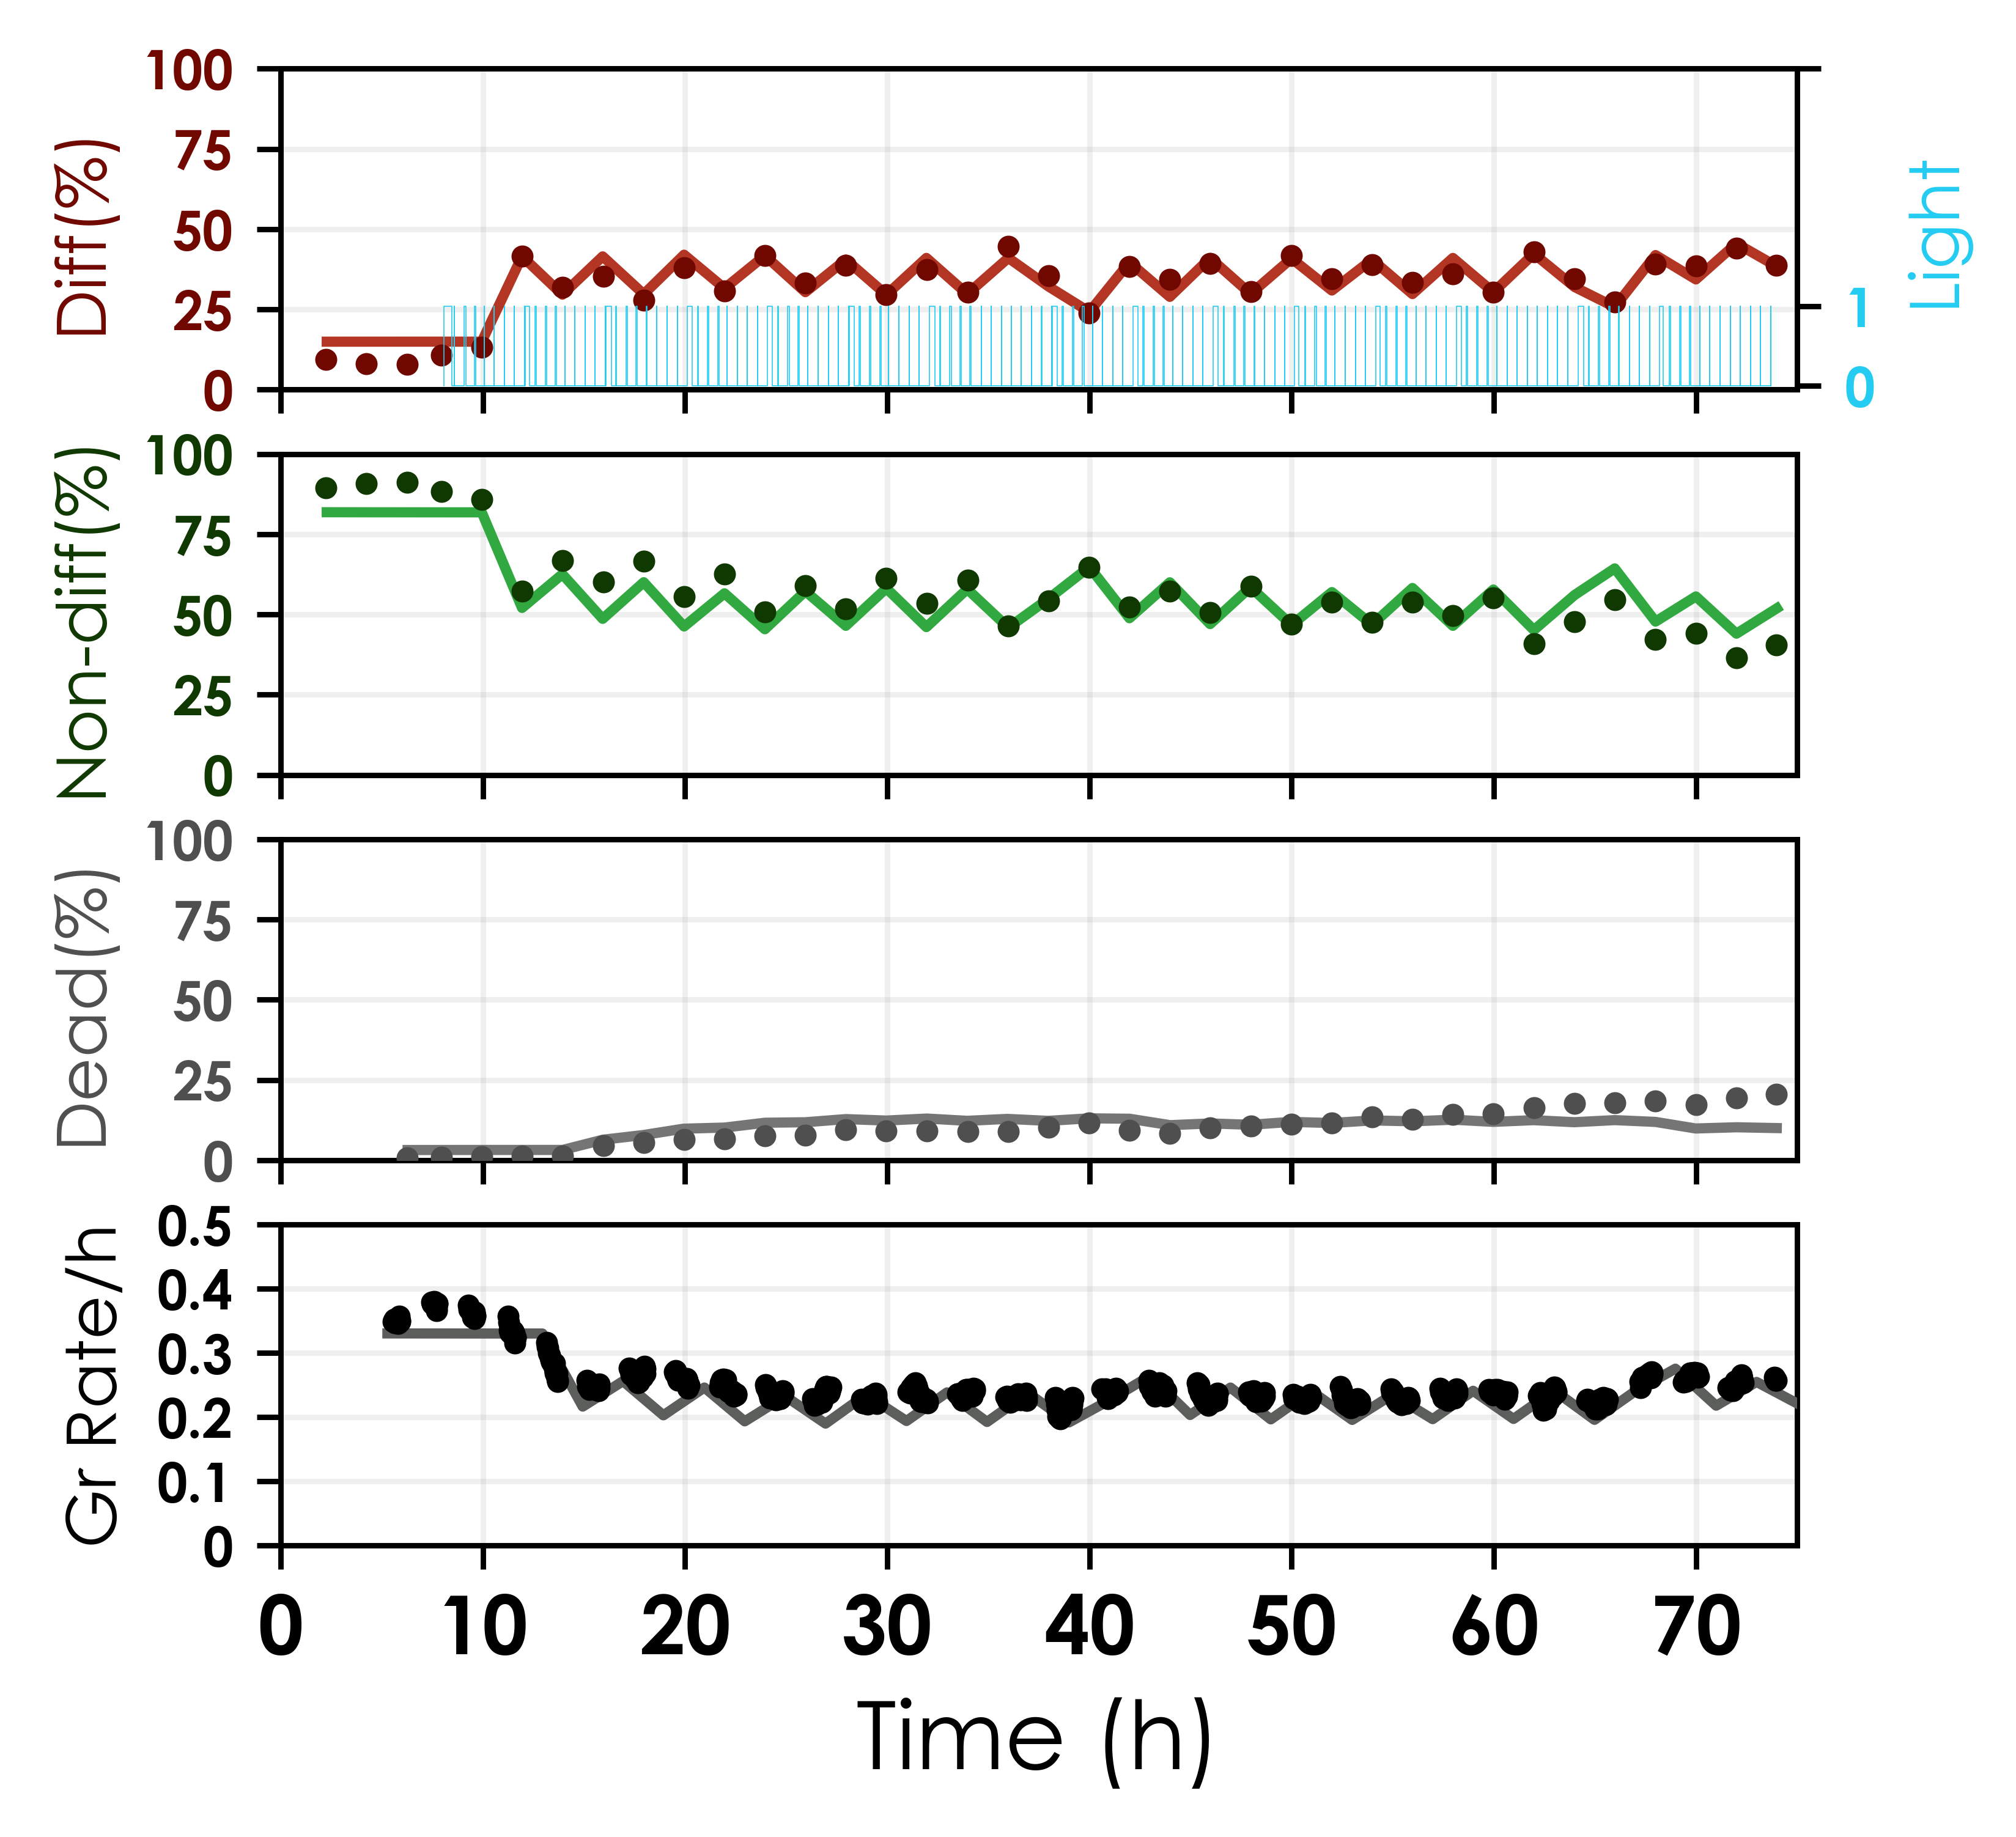

In [9]:
bdr = 0.0218654
dr = 0.9502541
drh = 2.5633357
er = 1.02358562e-7
dd = 0.18732584
params = [bdr,dr,er,dd]
bounds=([10e-10,10e-10,10e-10,10e-10], [10,10,10,10])
n_rec=1
n_dead = 3
n_gr =2
figure, axes7 = plt.subplots(4,1,figsize=(4,4),sharex = True, dpi=800, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
t_data,bg,t_span = fitted_data(all_data5[1],20,0.05,0.95)
z0 =[bg[0][1],bg[0][0],0,bg[0][2]]
fs = 14
p=  lsq(cost_function ,params,bounds = bounds,args =(z0,t_data,t_span,bg,n_rec,n_dead),verbose = 0, max_nfev=60 )
porus = p.x
print(porus)
easy_check(axes7,all_data5[1],porus,16,90,slider =30)

plt.savefig('../plots'+'/Figure4b.eps',bbox_inches='tight')
plt.savefig('../plots' +'/Figure4b.png',bbox_inches='tight')
plt.savefig('../plots'+'/Figure4b.svg',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

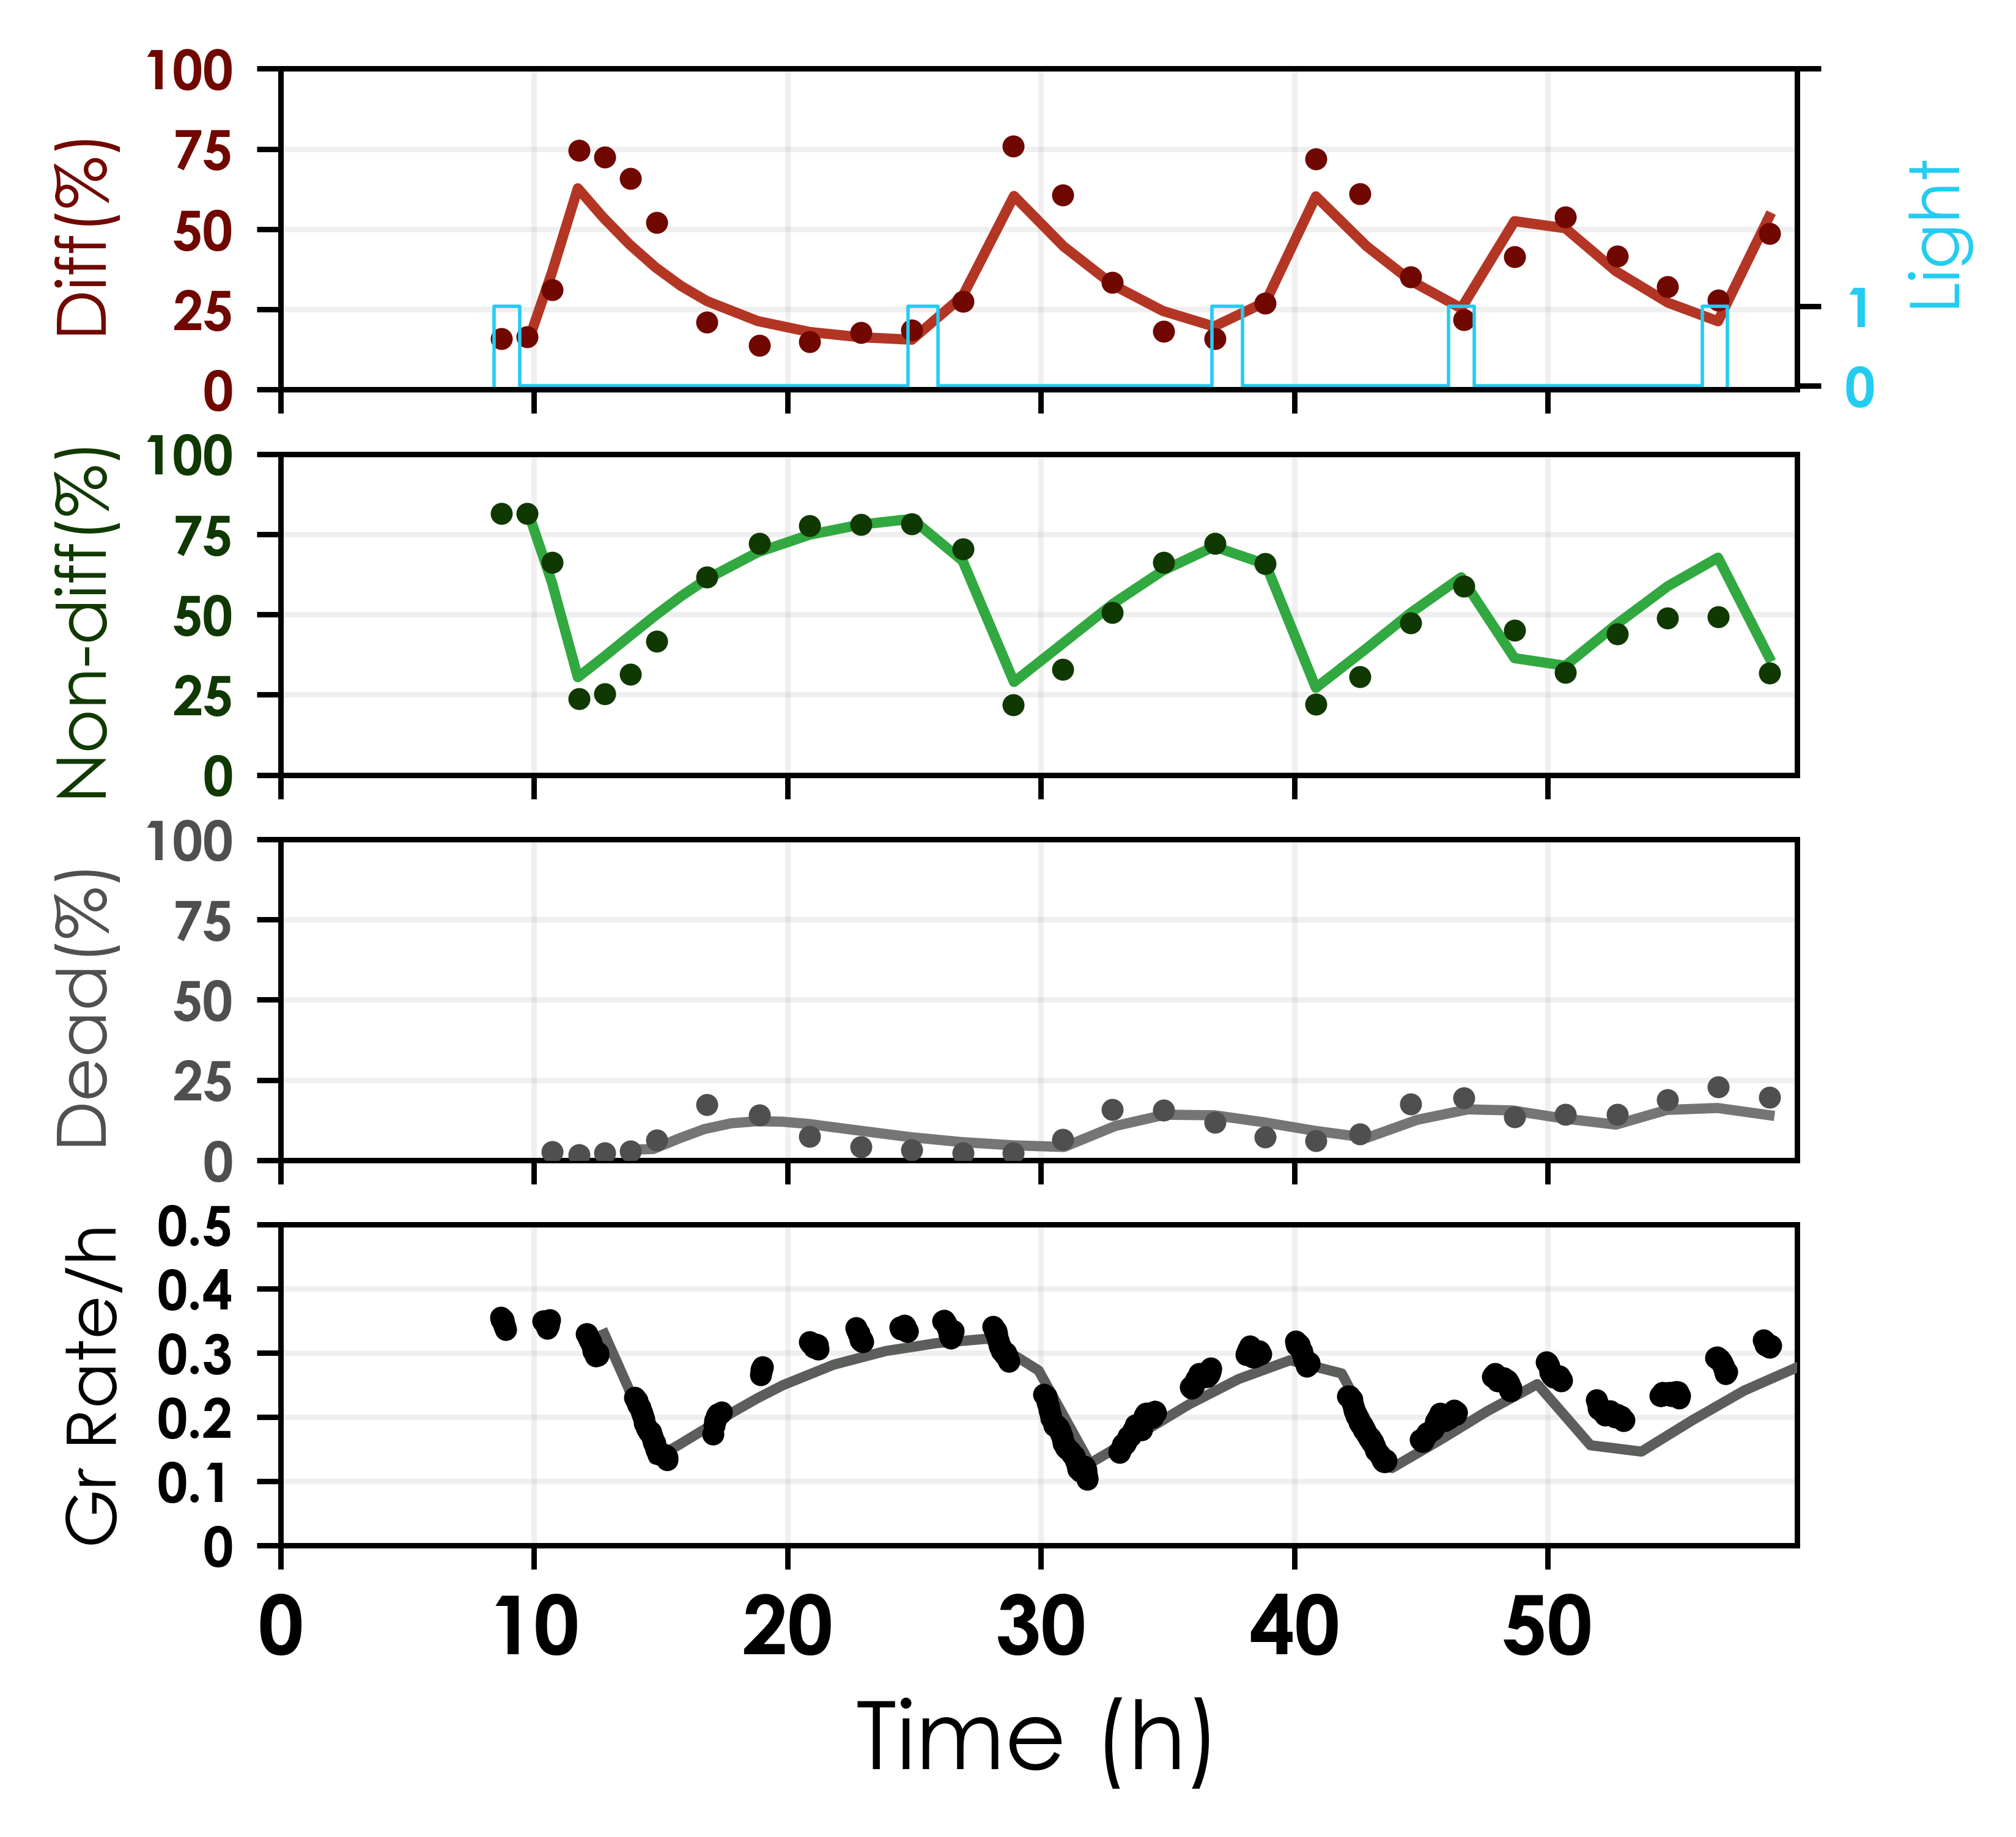

In [10]:
figure, axes7 = plt.subplots(4,1,figsize=(4,4),sharex = True, dpi=800, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
easy_check(axes7,all_data3[9],porus,0,90,slider =30,lw = 0.5)

plt.savefig('../plots'+'/Figure4c.eps',bbox_inches='tight')
plt.savefig('../plots' +'/Figure4c.png',bbox_inches='tight')
plt.savefig('../plots'+'/Figure4c.svg',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

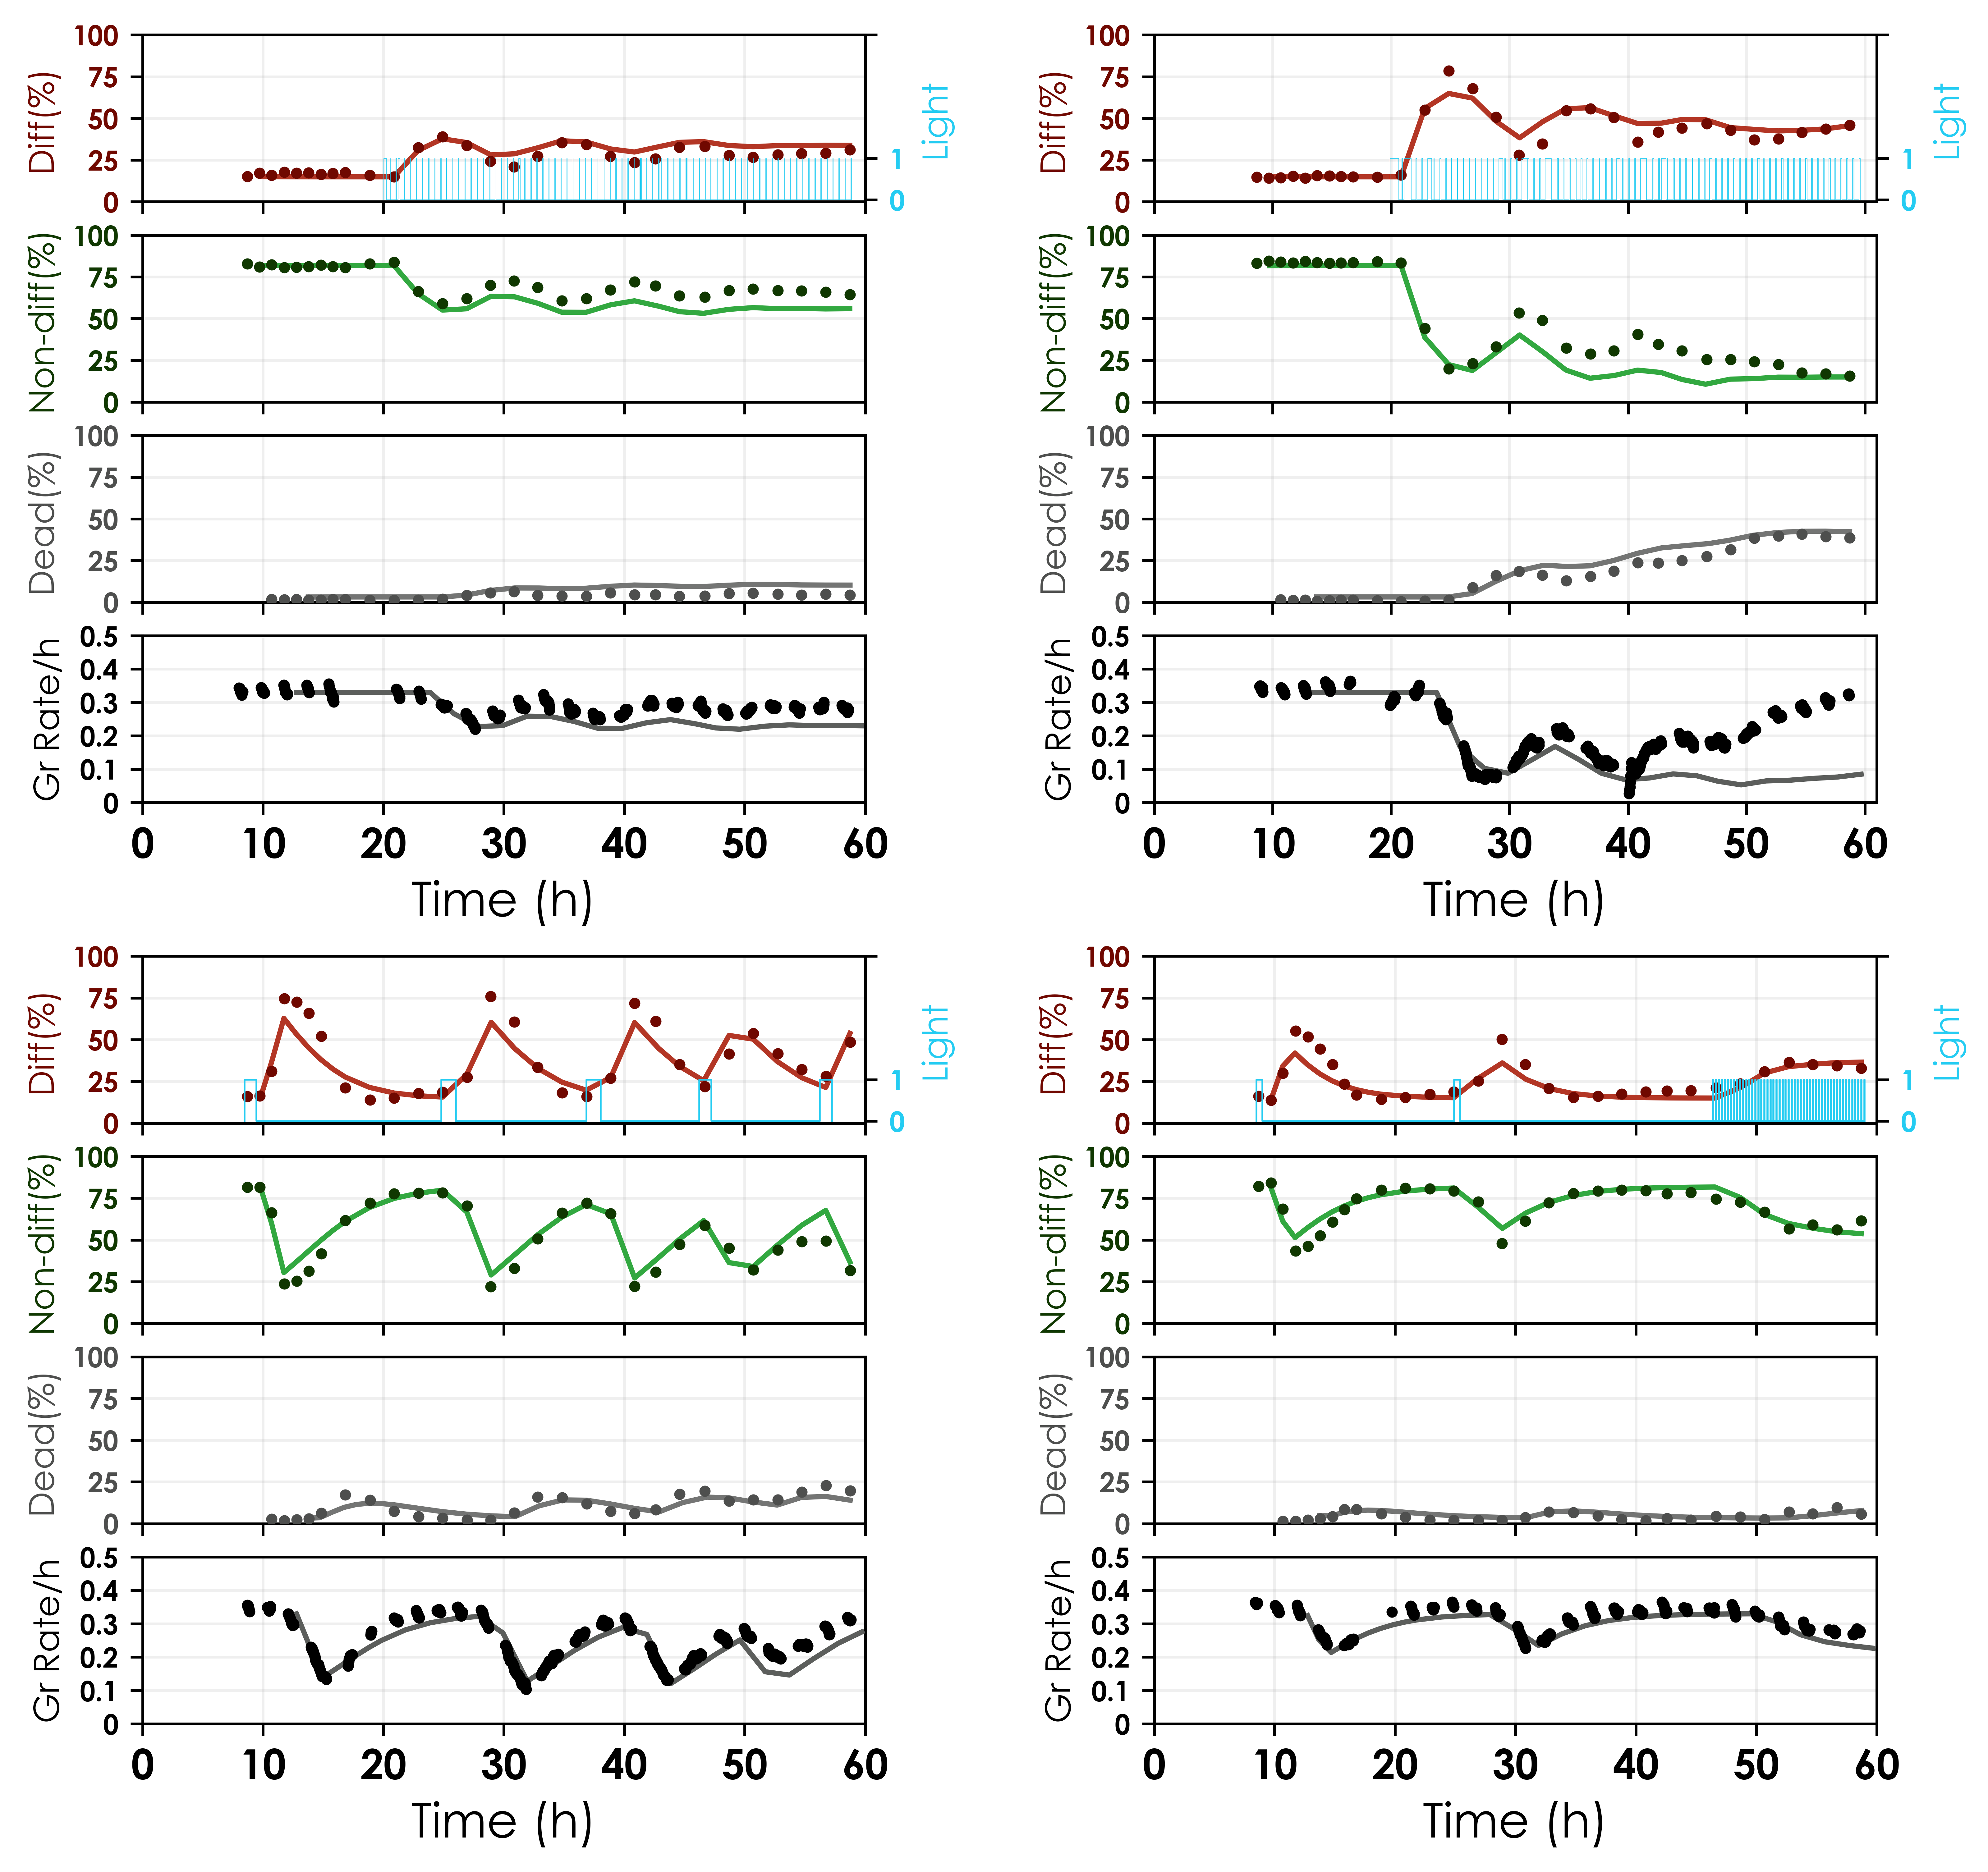

In [21]:
from matplotlib import gridspec as gridspec
fig = plt.figure(figsize=(9,9), dpi=800)
outer = gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.2)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(4, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.2)

    for j in range(4):
        ax = plt.Subplot(fig, inner[j])
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)
axes = fig.axes
axa1 = [axes[i] for i in range(4)]
axa2 = [axes[i] for i in range(4,8)]
axa3 = [axes[i] for i in range(8,12)]
axa4 = [axes[i] for i in range(12,16)]
axa = [axa1,axa2,axa3,axa4]
rids = [1,2,9,10]
t_start =0
t_end = 60
xticks = [0,10,20,30,40,50,60]
lw = [0.15,0.15,0.5,0.5]
for jj,axs in enumerate(axa):
    t_data,bg,t_span = fitted_data(all_data3[rids[jj]],0,0.05,0.95)
    easy_check(axs,all_data3[rids[jj]],porus,t_start,t_end,lw = lw[jj])
jj =1
for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels([])

    if jj%4 ==0:
        ax.set_xticklabels([str(i) for i in xticks])
    jj+=1

plt.savefig('../plots'+'/FigureS4.7.eps')
plt.savefig('../plots' +'/FigureS4.7.png')
plt.savefig('../plots'+'/FigureS4.7.svg')